# Titanic Survival Predictions


In [120]:
from datetime import datetime
import time

dt_object = datetime.fromtimestamp(time.time())
dt_object = str(dt_object).split('.')[0]

Date, Time = dt_object.split(' ')
print('Revised on: ' + Date)

Revised on: 2020-01-26


## Load Pre-Processed Data

In [124]:
# import modules
import pandas as pd
import numpy as np

# custom modules 
import modeling_functions as mf

# load pre-processed training data
train_data = pd.read_csv("./train_processed.csv")

# separate target from predictors in training set
survived_labels = train_data['Survived'].copy()
train_data_nolabel = train_data.drop('Survived', axis=1)

# drop numerical features which dominate, and IsMale which duplicates title
train_data_nolabel.drop(['IsMale','NameLength','FarePerPerson'], axis=1, inplace=True)

# get processed training data and labels
X = train_data_nolabel.to_numpy()
y = survived_labels.to_numpy()

## Modeling all Features

In [129]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import pickle

In [132]:
try:
    rf_grid_search = pickle.load(open('./RandomForest_GridSearch_5.sav', 'rb'))
except FileNotFoundError as e:
    num_estimators = list(range(300,500,15))
    
    grid_param = {
        'n_estimators': num_estimators,
        'criterion': ['entropy'],
        'bootstrap': [True]
    }
    
    rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                                    param_grid=grid_param,
                                    scoring='accuracy',
                                    cv=5,
                                    n_jobs=-1)
    
    # running the grid search: this takes time...
    rf_grid_search.fit(X, y)
    
    # pickle the model for future ease
    pickle.dump(rf_grid_search, open('./RandomForest_GridSearch_5.sav', 'wb'))

In [133]:
rf_grid_search.best_params_ , 'Accuracy: ' + str(round(rf_grid_search_1.best_score_, 3)*100) + '%'

({'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 390},
 'Accuracy: 82.19999999999999%')

## Training Best RF model plus Feature Selection

In [143]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# split training data into 20% test and 80% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# train best RF classifier
forest_clf = RandomForestClassifier(bootstrap=True, 
                                    criterion='entropy', 
                                    n_estimators=390, 
                                    random_state=42)

forest_clf.fit(X_train, y_train)

# select subset with most important features (threshold defined with elbow plot)
sfm = SelectFromModel(forest_clf, threshold=0.02)
sfm.fit(X_train, y_train)

# create subsets with most important features
X_train_imp = sfm.transform(X_train)
X_test_imp = sfm.transform(X_test)

# train a new model on this subset
forest_clf_imp =  RandomForestClassifier(bootstrap=True, 
                                        criterion='entropy', 
                                        n_estimators=390, 
                                        random_state=42)

forest_clf_imp.fit(X_train_imp, y_train)

# predict on the test set using the full dataset
y_pred = forest_clf.predict(X_test)
full_accuracy = str(round(accuracy_score(y_test, y_pred), 5)) 

# predict on the test set using the important subset model
y_pred_imp = forest_clf_imp.predict(X_test_imp)
important_accuracy = str(round(accuracy_score(y_test, y_pred_imp), 5)) 

print('Full data accuracy: ' + full_accuracy)
print('Important subset accuracy: ' + important_accuracy)

Full data accuracy: 0.79888
Important subset accuracy: 0.80447


### TEST

In [136]:
# Load test dataset
test_data = pd.read_csv("../input/test.csv")
test_PassengerId = test_data['PassengerId'].copy()

test_data_processed = pd.read_csv("./test_processed.csv")
test_data_processed.drop(['IsMale','NameLength','FarePerPerson'], axis=1, inplace=True)

X_test = test_data_processed.to_numpy()

X_test_imp = sfm.transform(X_test)

# get predictions using our two RF classifiers
y_pred_full = forest_clf.predict(X_test)
y_pred_imp = forest_clf_imp.predict(X_test_imp)

# full data CSV
dict_full = { 'PassengerId': test_PassengerId, 'Survived': pd.Series(y_pred_full) } 
rf_full = pd.DataFrame(dict_full) 
rf_full.to_csv('./rf_full3.csv', index=False)

# important subset CSV
dict_imp = { 'PassengerId': test_PassengerId, 'Survived': pd.Series(y_pred_imp) } 
rf_imp = pd.DataFrame(dict_imp) 
rf_imp.to_csv('./rf_imp3.csv', index=False)

### Elbow plot

In [139]:
from sklearn.feature_selection import SelectFromModel

# train full model on best classifier
forest_clf = RandomForestClassifier(bootstrap=True,
                                    criterion='entropy',
                                    n_estimators=390,
                                    random_state=42)
forest_clf.fit(X, y)

# create dataframe of labels and importance scores
importance_df = pd.DataFrame(list(zip(train_data_nolabel.columns, forest_clf.feature_importances_)),
                       columns=['Labels','Importance'])

importance_df.sort_values(by=['Importance'], ascending=False, inplace=True)

# plot an "elbow" plot of feature importance
plt.rcParams['figure.figsize'] = [14, 8]
mf.elbow_plot(importance_df['Labels'], 
           importance_df['Importance'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=390,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

## Submissions

The full model above got 0.79888 in validation and 0.77511 in the public test set.

The important model (see elbow plot) got 0.80447 in validation and 0.77990 in the public test set.

Add `Fare`?

In [145]:
# load pre-processed training data
train_data = pd.read_csv("./train_processed.csv")

# separate target from predictors in training set
survived_labels = train_data['Survived'].copy()
train_data_nolabel = train_data.drop('Survived', axis=1)

# drop numerical features which dominate, and IsMale which duplicates title -- keep FarePerPerson
train_data_nolabel.drop(['IsMale','NameLength'], axis=1, inplace=True)

# get processed training data and labels
X = train_data_nolabel.to_numpy()
y = survived_labels.to_numpy()

In [149]:
try:
    rf_grid_search = pickle.load(open('./RandomForest_GridSearch_6.sav', 'rb'))
except FileNotFoundError as e:
    num_estimators = list(range(350,450,2))
    
    grid_param = {
        'n_estimators': num_estimators,
        'criterion': ['entropy'],
        'bootstrap': [True]
    }
    
    rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                                    param_grid=grid_param,
                                    scoring='accuracy',
                                    cv=5,
                                    n_jobs=-1)
    
    # running the grid search: this takes time...
    rf_grid_search.fit(X, y)
    
    # pickle the model for future ease
    pickle.dump(rf_grid_search, open('./RandomForest_GridSearch_6.sav', 'wb'))

In [151]:
rf_grid_search.best_params_ , 'Accuracy: ' + str(round(rf_grid_search_1.best_score_, 3)*100) + '%'

({'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 384},
 'Accuracy: 82.19999999999999%')

### Training Best RF model plus Feature Selection

In [162]:
# split training data into 20% test and 80% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# train best RF classifier
forest_clf = RandomForestClassifier(bootstrap=True, 
                                    criterion='entropy', 
                                    n_estimators=384, 
                                    random_state=42)

forest_clf.fit(X_train, y_train)

# select subset with most important features (threshold defined with elbow plot)
sfm = SelectFromModel(forest_clf, threshold=0.02)
sfm.fit(X_train, y_train)

# create subsets with most important features
X_train_imp = sfm.transform(X_train)
X_test_imp = sfm.transform(X_test)

# train a new model on this subset
forest_clf_imp =  RandomForestClassifier(bootstrap=True, 
                                        criterion='entropy', 
                                        n_estimators=384, 
                                        random_state=42)

forest_clf_imp.fit(X_train_imp, y_train)

# predict on the test set using the full dataset
y_pred = forest_clf.predict(X_test)
full_accuracy = str(round(accuracy_score(y_test, y_pred), 5)) 

# predict on the test set using the important subset model
y_pred_imp = forest_clf_imp.predict(X_test_imp)
important_accuracy = str(round(accuracy_score(y_test, y_pred_imp), 5)) 

print('Full data accuracy: ' + full_accuracy)
print('Important subset accuracy: ' + important_accuracy)

Full data accuracy: 0.82123
Important subset accuracy: 0.82123


### TEST

In [154]:
# Load test dataset
test_data = pd.read_csv("../input/test.csv")
test_PassengerId = test_data['PassengerId'].copy()

test_data_processed = pd.read_csv("./test_processed.csv")
test_data_processed.drop(['IsMale','NameLength'], axis=1, inplace=True)

X_test = test_data_processed.to_numpy()
X_test_imp = sfm.transform(X_test)

# get predictions using our two RF classifiers
y_pred_full = forest_clf.predict(X_test)
y_pred_imp = forest_clf_imp.predict(X_test_imp)

# full data CSV
dict_full = { 'PassengerId': test_PassengerId, 'Survived': pd.Series(y_pred_full) } 
rf_full = pd.DataFrame(dict_full) 
rf_full.to_csv('./rf_full4.csv', index=False)

# important subset CSV
dict_imp = { 'PassengerId': test_PassengerId, 'Survived': pd.Series(y_pred_imp) } 
rf_imp = pd.DataFrame(dict_imp) 
rf_imp.to_csv('./rf_imp4.csv', index=False)

### Elbow plot

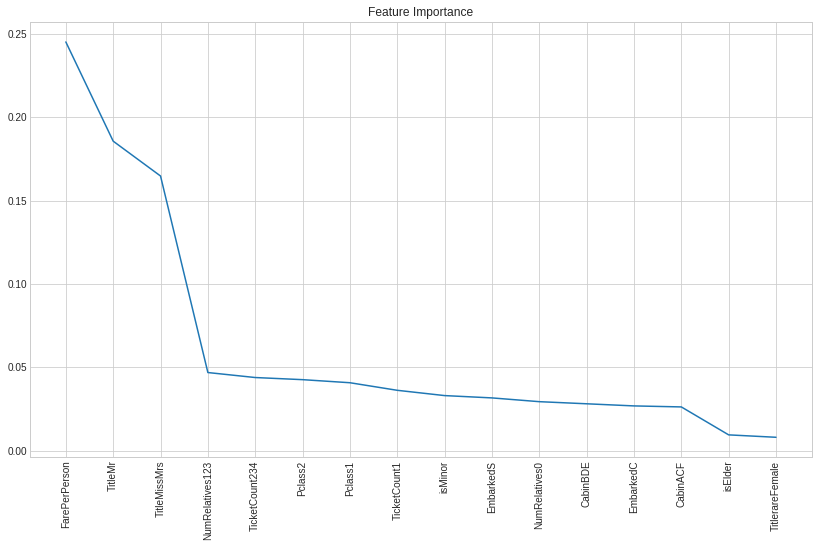

In [160]:
# train full model on best classifier
forest_clf = RandomForestClassifier(bootstrap=True,
                                    criterion='entropy',
                                    n_estimators=384,
                                    random_state=42)
forest_clf.fit(X, y)

# create dataframe of labels and importance scores
importance_df = pd.DataFrame(list(zip(train_data_nolabel.columns, forest_clf.feature_importances_)),
                       columns=['Labels','Importance'])

importance_df.sort_values(by=['Importance'], ascending=False, inplace=True)

# plot an "elbow" plot of feature importance
plt.rcParams['figure.figsize'] = [14, 8]
mf.elbow_plot(importance_df['Labels'],#[importance_df['Importance']>.02], 
              importance_df['Importance']#[importance_df['Importance']>.02]
             )

## Submissions

The full model above got 0.82123 in validation, predicted 152 survivals, and 0.78468 in the public test set.

The important model (see elbow plot) got 0.82123 in validation, predicted 160 survivals, and also got 0.78468 in the public test set.

### XGBoost

In [117]:
from xgboost import XGBClassifier

# split training data into 20% test and 80% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# default model
xgb_def = XGBClassifier()
xgb_def.fit(X_train, y_train)
y_pred_def = xgb_def.predict(X_test)
accuracy_def = accuracy_score(y_test, y_pred_def)


xgb_best = XGBClassifier(objective='binary:logistic', 
                         colsample_bytree=0.8, 
                         learning_rate=0.15,
                         n_estimators=150,
                         random_state=42)

# best model
xgb_best.fit(X_train, y_train)
y_pred_best = xgb_best.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)

xgb_third = XGBClassifier(objective='binary:logistic', 
                          colsample_bytree=0.8, 
                          learning_rate=0.1,
                          max_depth=3,
                          n_estimators=250,
                          reg_alpha=10,
                          random_state=42)

# a third model
xgb_third.fit(X_train, y_train)
y_pred_third = xgb_third.predict(X_test)
accuracy_third = accuracy_score(y_test, y_pred_third)

print("Accuracy with defaults: %.2f%%" % (accuracy_def * 100.0))
print("Accuracy w/ best model: %.2f%%" % (accuracy_best * 100.0))
print("Accuracy w/ third model: %.2f%%" % (accuracy_third * 100.0))

Accuracy with defaults: 81.01%
Accuracy w/ best model: 80.45%
Accuracy w/ third model: 82.12%


In [ ]:
xgb_third.fit(X_test, )

## Submission

I just submitted my first prediction in Kaggle, the XGBoost classifier which got 84.41% accuracy during validation but only 73.68% accuracy on the public leaderboard test subset, so it lost 10% accuracy when generalizing and was probably overfitting.